# Pneumonia Medical Imaging Analysis

In [69]:
# tensorflow packages 
import tensorflow as tf 

# general packages
import matplotlib.pyplot as plt
import numpy as np
import PIL
import PIL.Image
import pathlib
from datetime import datetime


Tensorflow Version 

In [70]:
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.10.0


GPU Check 

In [71]:
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2022-12-04 10:52:04.588991: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-04 10:52:04.589013: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Seed

In [72]:
SEED = 0
np.random.seed(SEED)

## Image Preprocessing

Load Dataset

In [73]:
# Static variables
IMAGE_SIZE = 200
BATCH_SIZE = 32

# directory path 
data_file = './chest_xray'
data_dir = pathlib.Path(data_file)

# count number of images
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(f"Number of Images: {image_count}" )

Number of Images: 5856


Display a Sample Image

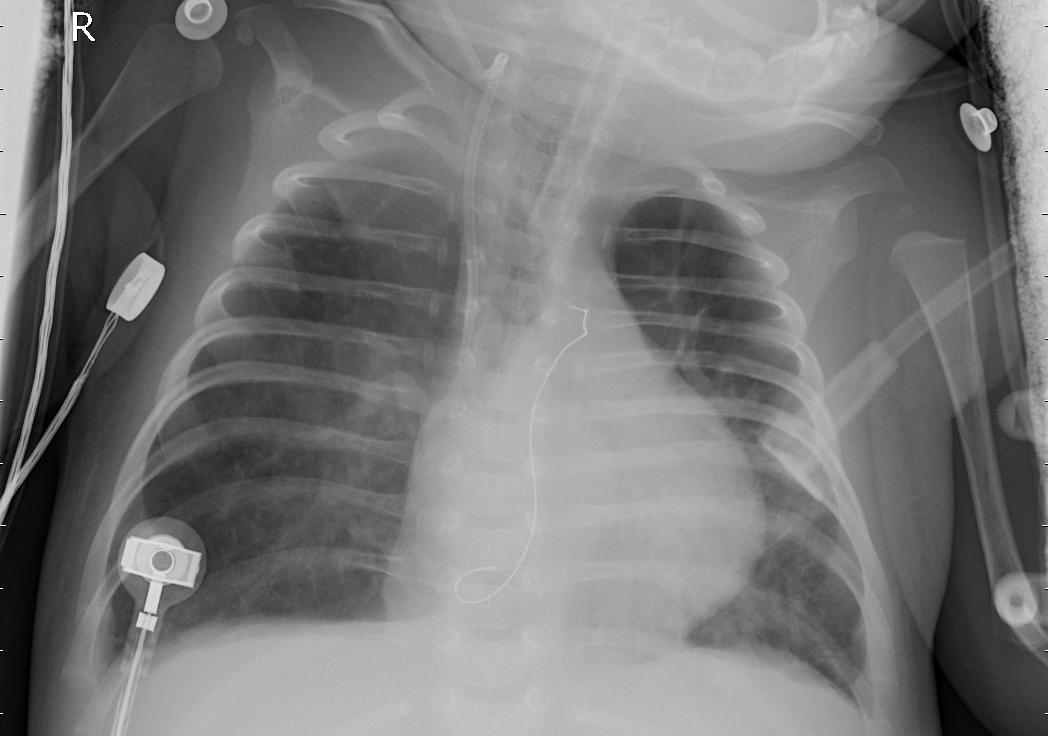

In [74]:
p = list(data_dir.glob('PNEUMONIA/*'))
PIL.Image.open(str(p[0]))

Establish Training and Validation Data Split 

In [75]:
train = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels= 'inferred',
  validation_split=0.2,
  subset="training",
  seed=SEED,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

val = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels= 'inferred',
  validation_split=0.2,
  subset="validation",
  seed=SEED,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 5856 files belonging to 2 classes.
Using 4685 files for training.
Found 5856 files belonging to 2 classes.
Using 1171 files for validation.


Dataset Tensorflow Optimization 

In [76]:
AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

### Create and Fit Model   

Preprocessing Layer

In [77]:
preprocessing_layer = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE), # resize 
    tf.keras.layers.Rescaling(1./255), # rescale
    tf.keras.layers.RandomFlip("horizontal",input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)), # flip
    tf.keras.layers.RandomRotation(0.3), # rotate
    tf.keras.layers.RandomZoom(0.2), # zoom
])

Model 

In [78]:
num_classes = 2

model = tf.keras.Sequential([
  preprocessing_layer,
  
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(64, 9, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(64, 9, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

Compile Model 

In [79]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Fit the Model onto the Dataset

In [80]:
# number of epochs 
epochs = 30

# Early Stopping callback to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# TensorBoard callback
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tboard = tf.keras.callbacks.TensorBoard(log_dir = logs, histogram_freq = 1, profile_batch = '500,520')

# fit model
history = model.fit(
  train,
  validation_data= val,
  epochs=epochs,
  callbacks= [es, tboard],
)

Epoch 1/30


2022-12-04 10:52:05.402258: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2022-12-04 10:52:05.402268: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2022-12-04 10:52:05.402317: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


2022-12-04 10:52:06.986433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 24/147 [===>..........................] - ETA: 1:24 - loss: 0.5946 - accuracy: 0.7005

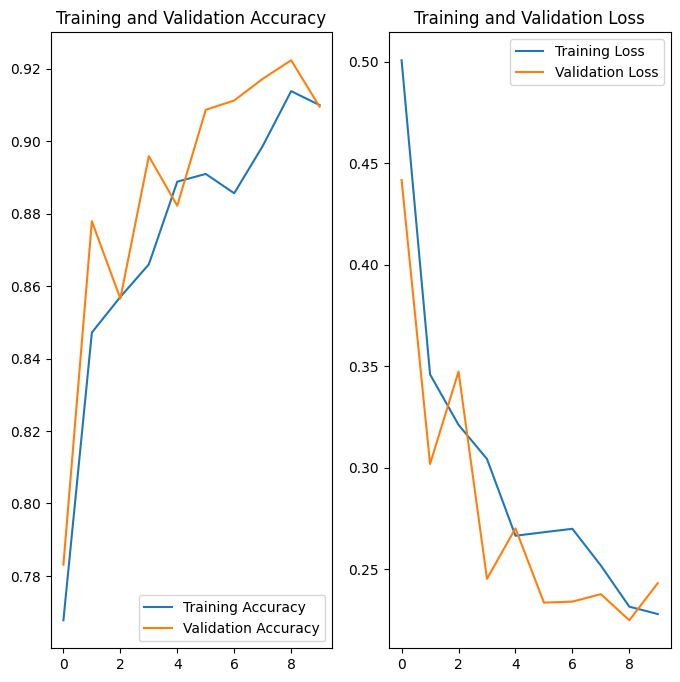

In [ ]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir=logs